# HAlphaAnomalyzer Demo
- Author: Mahsa Khazaei (mkdgy@umsystem.edu), Heba Mahdi, Azim Ahmadzadeh 
- University of Missouri - St. Louis
- Last modified date: Sep 28, 2024

#### Summary

The anomaly-detection process begins with sampling equal-sized GONG H-Alpha solar observation images, both anomalous and non-anomalous. Each image is partitioned into an nxn grid, dividing it into n² cells, and the average pixel intensity for each cell is computed, effectively downsampling the image to a grid of average values. Next, a one-way ANOVA F-test statistically analyzes the two groups of classified data, refining the normal intensity range for each cell. This method optimizes the upper and lower bounds for each cell's intensity using the statistic S = |U - I| + |L - I|, where U and L are candidate upper and lower bounds, and I is the cell's average pixel intensity. This ensures accurate detection of cells with significantly deviant pixel intensities. A cell is flagged as anomalous if its Sigmoid-transformed standardized S statistic value (anomaly likelihood) exceeds a specified threshold. Furthermore, an entire image is classified as anomalous if it surpasses a predefined minimum number of corrupt cells.

#### Import necessary libraries

In [1]:
import os
import sys
import random
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score

module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)

from HAlphaAnomalyzer.anomalyzer import Anomalyzer

#### Set up training set

In [2]:
# Define folder paths for anomalous and non-anomalous images
anomalous_folder_path     = '../_data_for_demo/_anomalous_images'
non_anomalous_folder_path = '../_data_for_demo/_non-anomalous_images'

# Normalize the folder paths to current OS
anomalous_folder_path = os.path.normpath(anomalous_folder_path)
non_anomalous_folder_path = os.path.normpath(non_anomalous_folder_path)

# Get paths of all anomalous images in a list
anomalous_paths = [
    os.path.join(anomalous_folder_path, file_name)
    for file_name in os.listdir(anomalous_folder_path)
    if file_name.lower().endswith(('.jpg', '.jpeg', '.png'))
]

# Get paths of all non-anomalous images in a list
non_anomalous_paths = [
    os.path.join(non_anomalous_folder_path, file_name)
    for file_name in os.listdir(non_anomalous_folder_path)
    if file_name.lower().endswith(('.jpg', '.jpeg', '.png'))
]

# Randomly sample anomalous and non-anomalous image paths
random.seed(123)
sampled_anomalous_paths = random.sample(anomalous_paths, 20)
sampled_non_anomalous_paths = random.sample(non_anomalous_paths, 20)

#### Initialize Anomalyzer with grid size and compute best ranges

Notes: 
1. Running this cell takes approximately 10 minutes with 40 sampled training images on a typical personal computer.
2. Ensure that the training images include at least one image with issues in all four corners. This is necessary to prevent the F-statistics of the One-way ANOVA F-test from becoming undefined (resulting in `nan` and raising a `ConstantInputWarning`) due to constant average pixel values (e.g., 0.0) in those corner cells. Any nan F-statistics resulting from undefined calculations are handled by replacing them with a unique value (i.e., -1), ensuring accurate ranking of candidate ranges based on F-statistics.

In [3]:
anomalyzer = Anomalyzer(grid_size=8)
anomalyzer.compute_best_ranges(sampled_non_anomalous_paths, sampled_anomalous_paths)

Computing Statistics: 100%|███████████████| 2560/2560 [00:01<00:00, 1407.96it/s]


#### Set up test set

In [4]:
# Combine sampled non-anomalous and anomalous paths of the training set
training_img_paths = sampled_non_anomalous_paths + sampled_anomalous_paths

# Identify anomalous and non-anomalous test images that are not part of the training set
anomalous_test_img_paths = [path for path in anomalous_paths if path not in training_img_paths]
non_anomalous_test_img_paths = [path for path in non_anomalous_paths if path not in training_img_paths]

# Label anomalous test images with 1 and non-anomalous test images with 0
anomalous_test_img_labels = [1] * len(anomalous_test_img_paths)
non_anomalous_test_img_labels = [0] * len(non_anomalous_test_img_paths)
# Combine anomalous and non-anomalous test image paths
test_img_paths = anomalous_test_img_paths + non_anomalous_test_img_paths

# Combine labels for the test images
test_img_labels = anomalous_test_img_labels + non_anomalous_test_img_labels

#### Find corrupt images in the test set by returning a list of binary labels, where 0 indicates a non-corrupt image and 1 indicates a corrupt image.

In [5]:
corrupt_images_labels = anomalyzer.find_corrupt_images(test_img_paths, 
                                                       likelihood_threshold=0.6, 
                                                       min_corrupt_cells=1, 
                                                       verbose=True)

Detecting Corrupt Images: 100%|█████████████| 160/160 [00:00<00:00, 1109.35it/s]

Number of corrupt images detected: 85


#### Plot the anomaly likelihoods of grid cells for a specific image using a colormap, and mark corrupt cells based on a likelihood threshold, if provided

Computing Anomaly Likelihoods: 100%|██████████████| 1/1 [00:00<00:00, 10.53it/s]


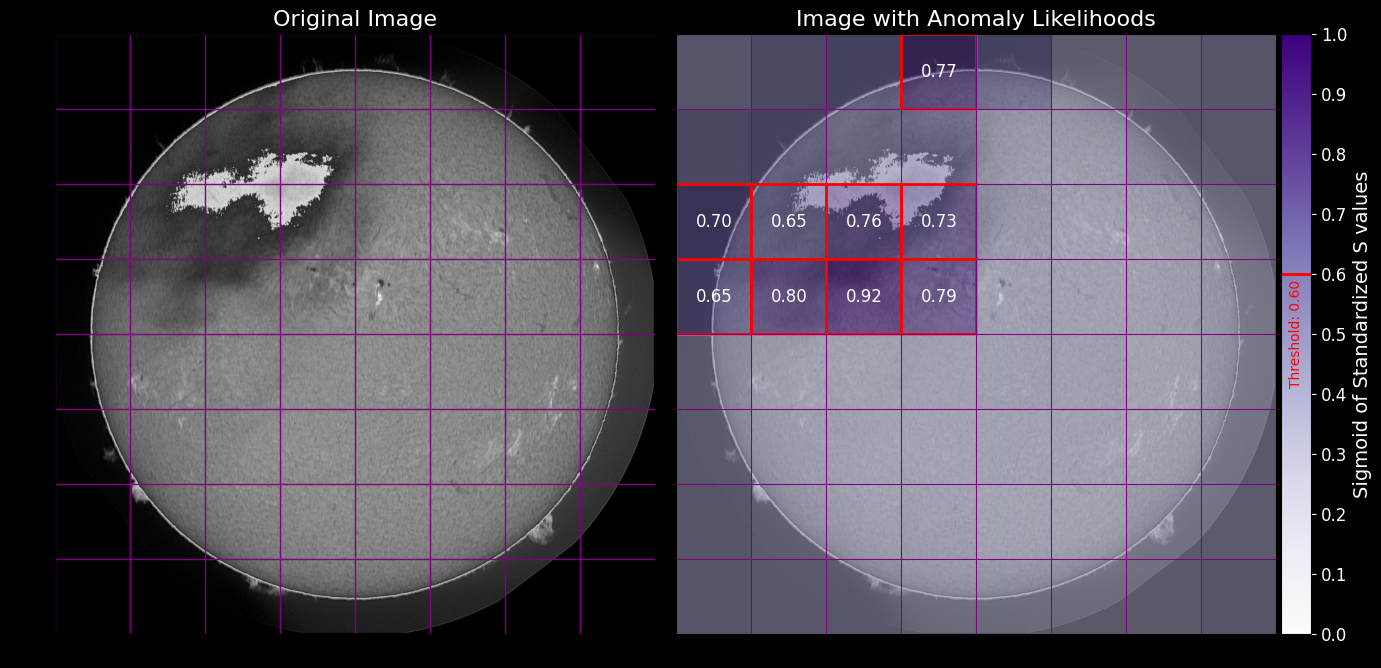

In [6]:
anomalyzer.plot_image_likelihoods(os.path.normpath('../_data_for_demo/_anomalous_images/20130114105034Ch.jpeg'), likelihood_threshold=0.6)

#### Plot confusion matrix and print F1 score for performance evaluation

F1 Score: 0.9696969696969697


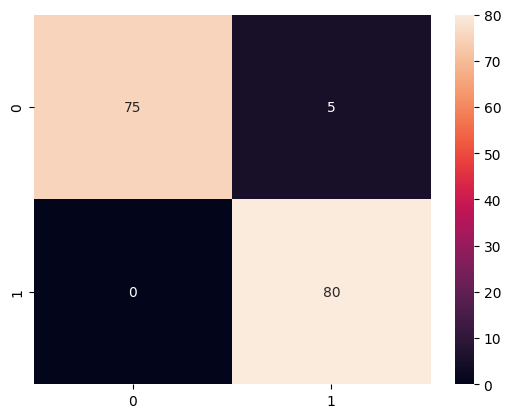

In [7]:
sns.heatmap(confusion_matrix(test_img_labels, corrupt_images_labels), annot=True, fmt='d')
print('F1 Score: ' + str(f1_score(test_img_labels, corrupt_images_labels)))